# Bias Variance Tradeoff

Author: https://github.com/deburky

$ \text{MSE} = \mathbb{E}[(y - \hat{y})^2]$

$\mathbb{E}[(y - \hat{y})^2] = (y - \mathbb{E}[\hat{y}])^2 + \mathbb{E}[(\mathbb{E}[\hat{y}] - \hat{y})^2]$

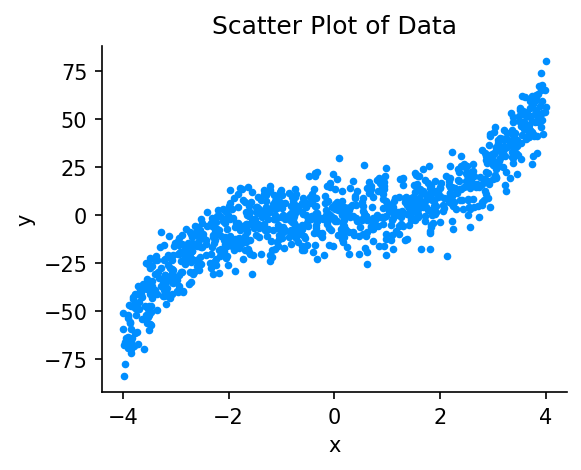

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# simulate data that is curvilinear
np.random.seed(0)

# Simulate data that is curvilinear
n_points = 1000
x = np.random.uniform(-4, 4, n_points)
y = x**3 + np.random.normal(0, 1, n_points)
y += np.random.normal(0, 10, n_points)

fig = plt.figure(figsize=(4, 3), dpi=150)
plt.scatter(x, y, color="#008eff", s=7)
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title("Scatter Plot of Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Linear Regression

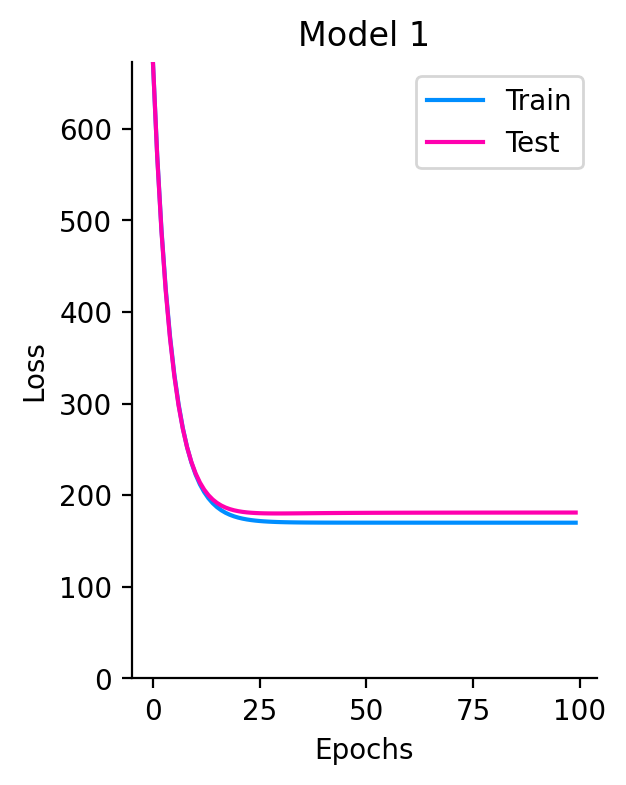

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin


class LinearEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, epochs=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.theta0 = 0
        self.theta1 = 0
        self.loss_history = []
        self.val_loss_history = []

    def predict(self, X):
        return np.dot(X, self.theta1) + self.theta0

    def fit(self, X, y, X_val=None, y_val=None):
        m = len(y)
        for _ in range(self.epochs):
            y_pred = self.predict(X)
            error = y_pred - y
            loss = (1 / m) * np.sum(error**2)
            self.loss_history.append(loss)

            if X_val is not None and y_val is not None:
                val_loss = self.evaluate(X_val, y_val)
                self.val_loss_history.append(val_loss)

            self.theta0 -= self.learning_rate * (2 / m) * np.sum(error)
            self.theta1 -= self.learning_rate * (2 / m) * np.sum(error * X)

    def evaluate(self, X_val, y_val):
        y_val_pred = self.predict(X_val)
        return (1 / len(y_val)) * np.sum((y_val_pred - y_val) ** 2)


# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

# Initialize and train the Linear Regression model
lr = LinearEstimator(epochs=100, learning_rate=0.01)
lr.fit(X_train, y_train, X_val, y_val)
predictions = lr.predict(X_val)

# Plot training and validation loss history
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 4), dpi=200)
plt.plot(lr.loss_history, label="Train", color="#008eff")
plt.plot(lr.val_loss_history, label="Test", color="#ff00af")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, np.max(lr.loss_history))
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.title("Model 1")
plt.show()

MSE: 170.0525


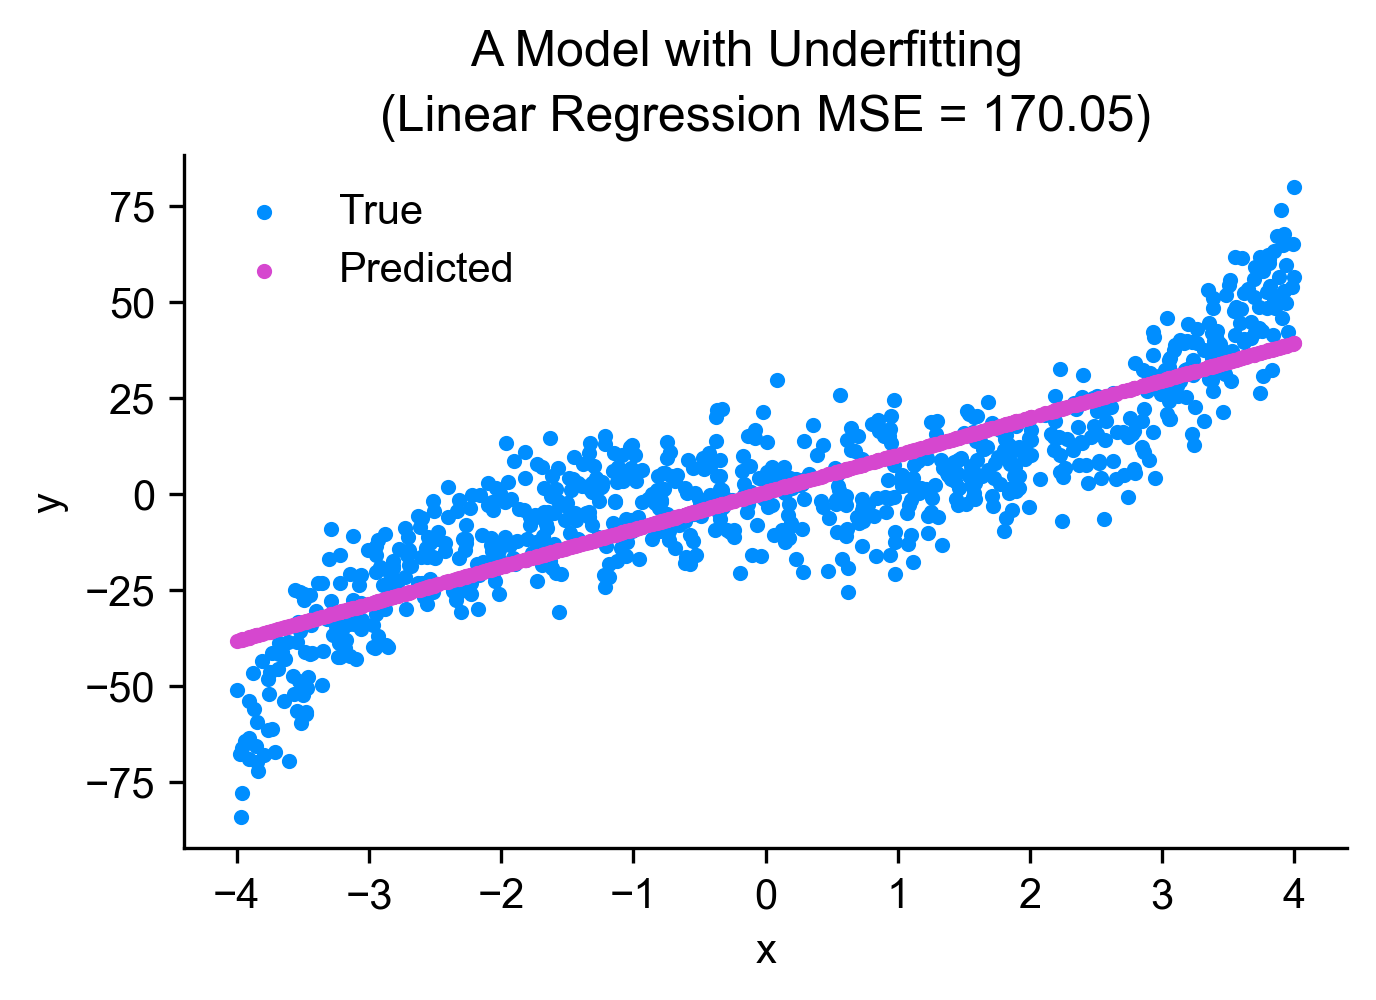

In [3]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# retina display
%config InlineBackend.figure_format = 'retina'

# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

y_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
print(f"MSE: {mse:.4f}")

fig = plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X_train, y_train, color="#008eff", label="True", s=7)
plt.scatter(X_train, y_pred, color="#d647cf", label="Predicted", s=7)
# show in legend colors not dots
plt.legend(frameon=False)
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title(f"(Linear Regression MSE = {mse:.2f})")
plt.suptitle("A Model with Underfitting", y=1.02)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Gradient Boosting

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


class SquaredLoss:
    @staticmethod
    def compute_gradients(y_true, y_pred):
        return y_pred - y_true

    @staticmethod
    def compute_hessians(y_true, y_pred):
        return np.ones_like(y_true)  # Hessian is constant for squared loss

    @staticmethod
    def raw_predictions_to_proba(raw_predictions):
        return raw_predictions  # For regression, raw predictions are the output


class BaseGradientBoosting(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        n_iter=100,
        max_depth=3,
        learning_rate=0.1,
        loss=SquaredLoss(),
        base_learner="tree",
    ):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.max_depth = max_depth
        self.predictors = []
        self.loss_history = []
        self.val_loss_history = []
        self.base_learner_type = base_learner

    def fit(self, X, y, X_val=None, y_val=None):
        y_pred_train = np.zeros(X.shape[0], dtype=np.float64)

        # reshape x and y if they are 1D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            if X_val is not None:
                X_val = X_val.reshape(-1, 1)  # type: ignore

        for _ in range(self.n_iter):
            negative_gradient = -self.loss.compute_gradients(y, y_pred_train)

            if self.base_learner_type == "tree":
                new_predictor = DecisionTreeRegressor(max_depth=self.max_depth)
            elif self.base_learner_type == "linear":
                new_predictor = LinearRegression()

            new_predictor.fit(X, self.learning_rate * negative_gradient)
            y_pred_train += new_predictor.predict(X)

            self.predictors.append(new_predictor)
            train_loss = mean_squared_error(y, y_pred_train)
            self.loss_history.append(train_loss)

            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                val_loss = mean_squared_error(y_val, y_pred_val)
                self.val_loss_history.append(val_loss)

    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        return np.sum([predictor.predict(X) for predictor in self.predictors], axis=0)


class GradientBooster(BaseGradientBoosting, RegressorMixin):
    def __init__(
        self,
        n_iter=100,
        max_depth=3,
        learning_rate=0.1,
        loss=SquaredLoss(),
        base_learner="tree",
    ):
        super().__init__(n_iter, max_depth, learning_rate, loss, base_learner)


# Gradient Boosting Regressor model
gbr = GradientBooster(n_iter=50, max_depth=10, learning_rate=0.1, base_learner="tree")
gbr.fit(X_train, y_train, X_val, y_val)

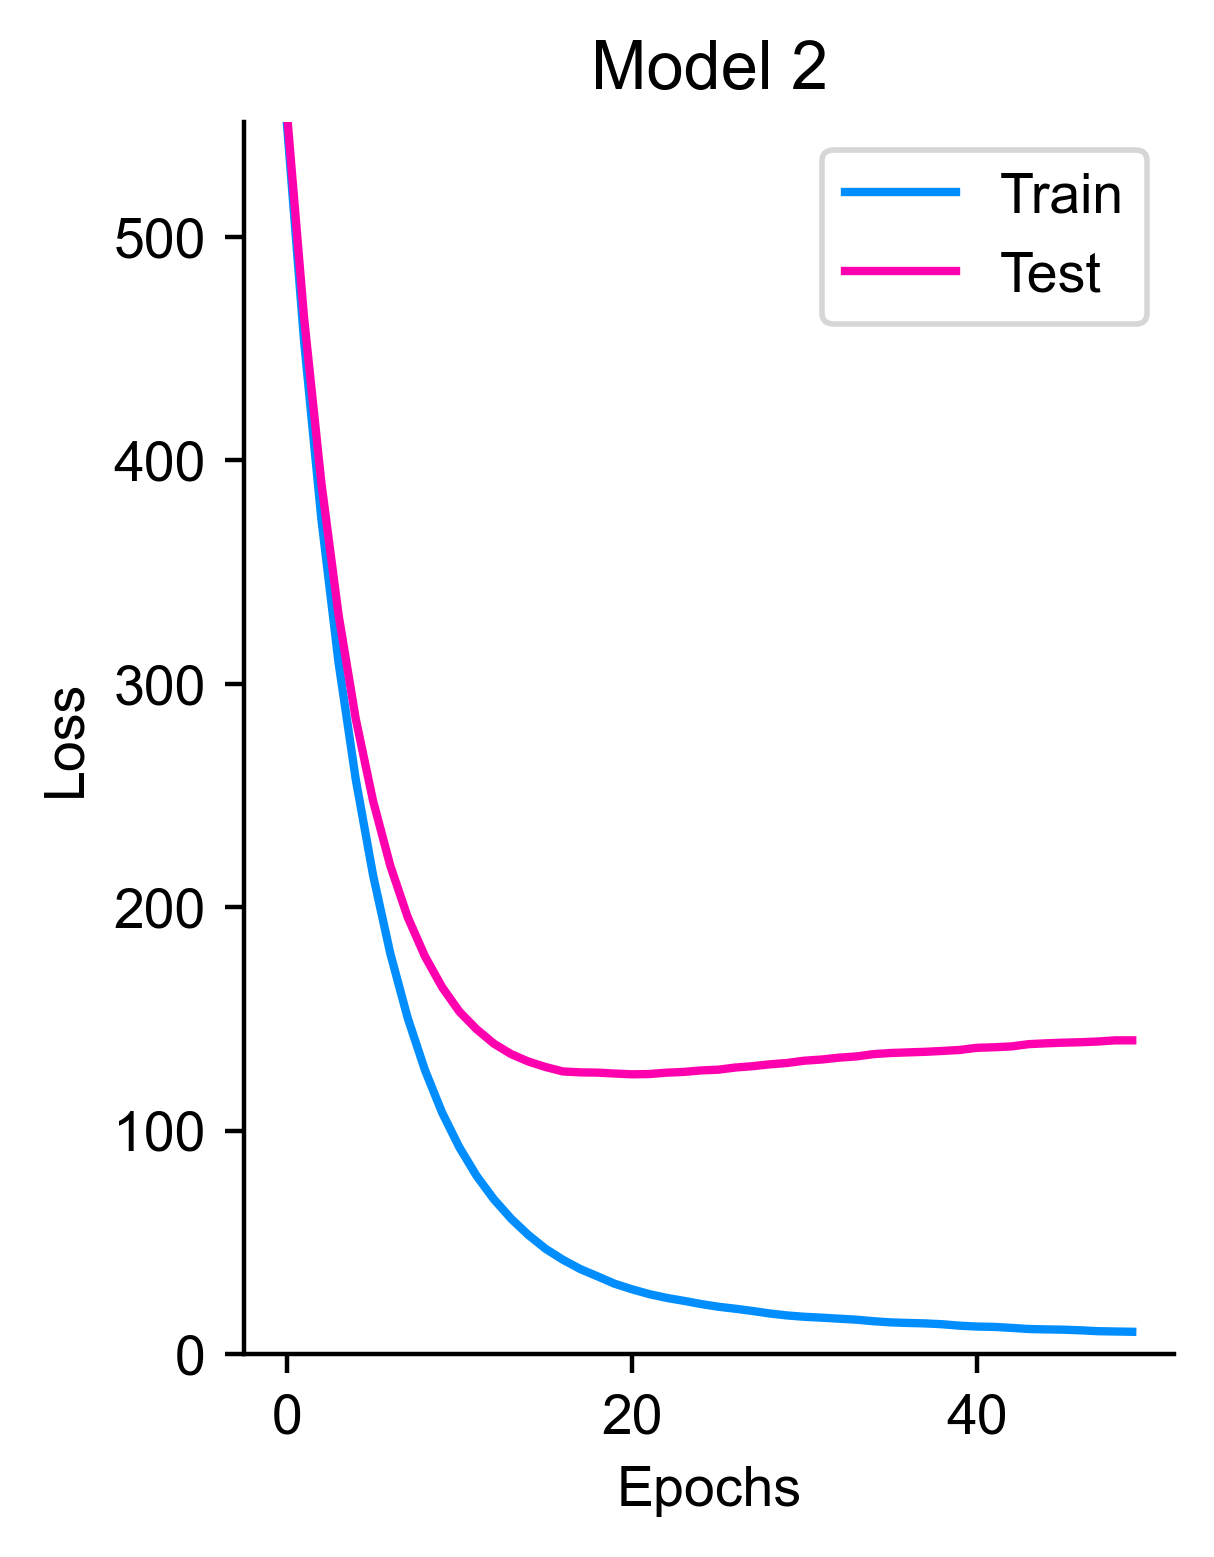

In [5]:
# Plot training and validation loss history
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 4), dpi=200)
plt.plot(gbr.loss_history, label="Train", color="#008eff")
plt.plot(gbr.val_loss_history, label="Test", color="#ff00af")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, np.max(gbr.loss_history))
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.title("Model 2")
plt.show()

MSE: 9.8983


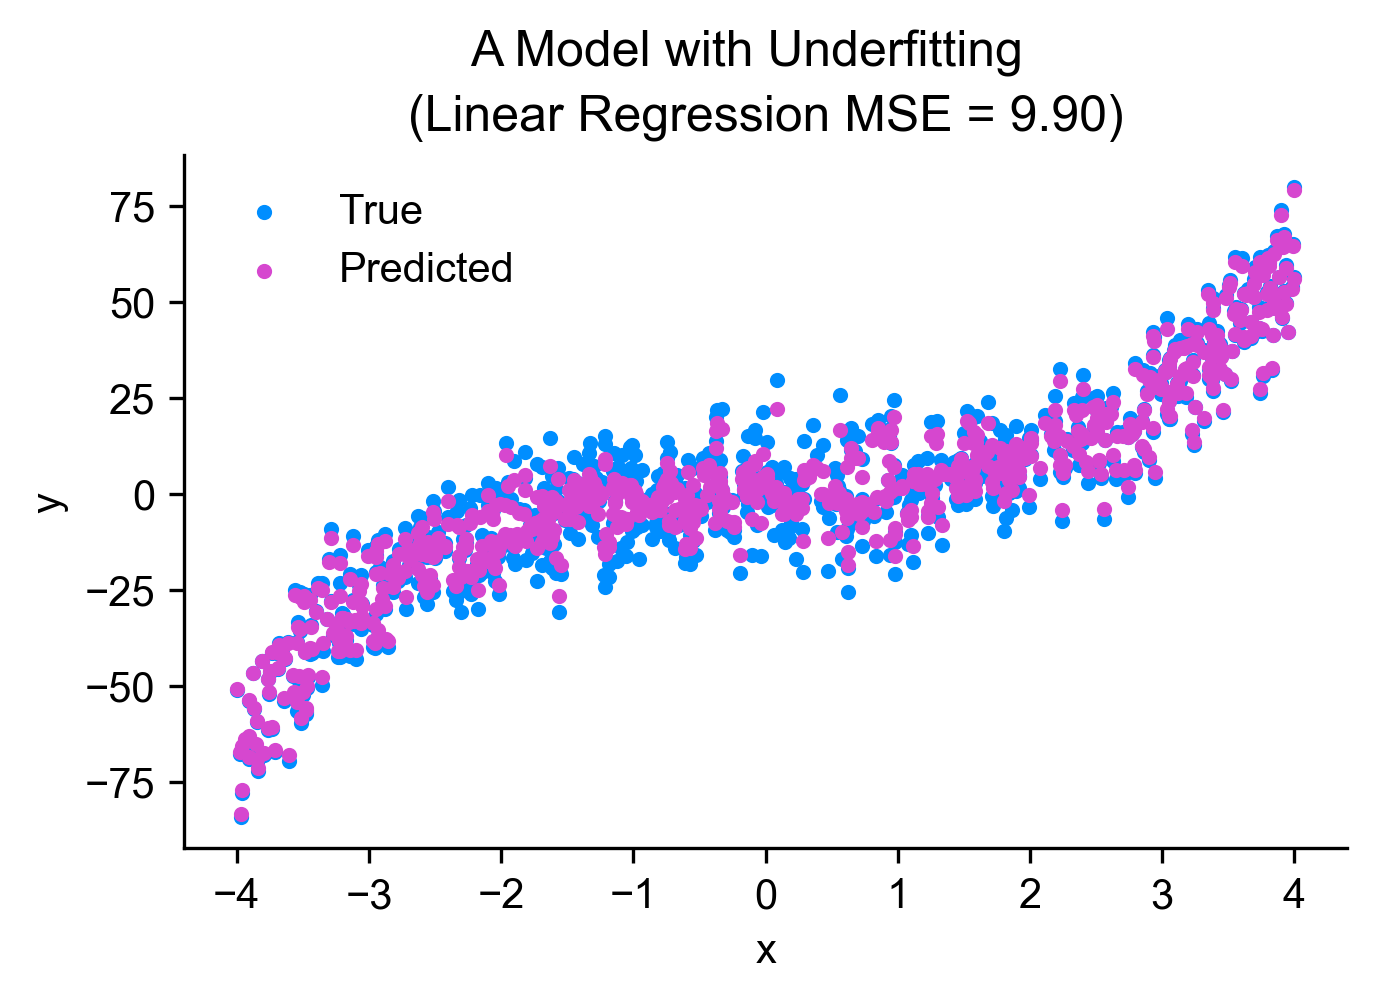

In [6]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# retina display
%config InlineBackend.figure_format = 'retina'

# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

y_pred = gbr.predict(X_train.reshape(-1, 1))

mse = mean_squared_error(y_train, y_pred)
print(f"MSE: {mse:.4f}")

fig = plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X_train, y_train, color="#008eff", label="True", s=7)
plt.scatter(X_train, y_pred, color="#d647cf", label="Predicted", s=7)
# show in legend colors not dots
plt.legend(frameon=False)
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title(f"(Linear Regression MSE = {mse:.2f})")
plt.suptitle("A Model with Underfitting", y=1.02)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## MLP

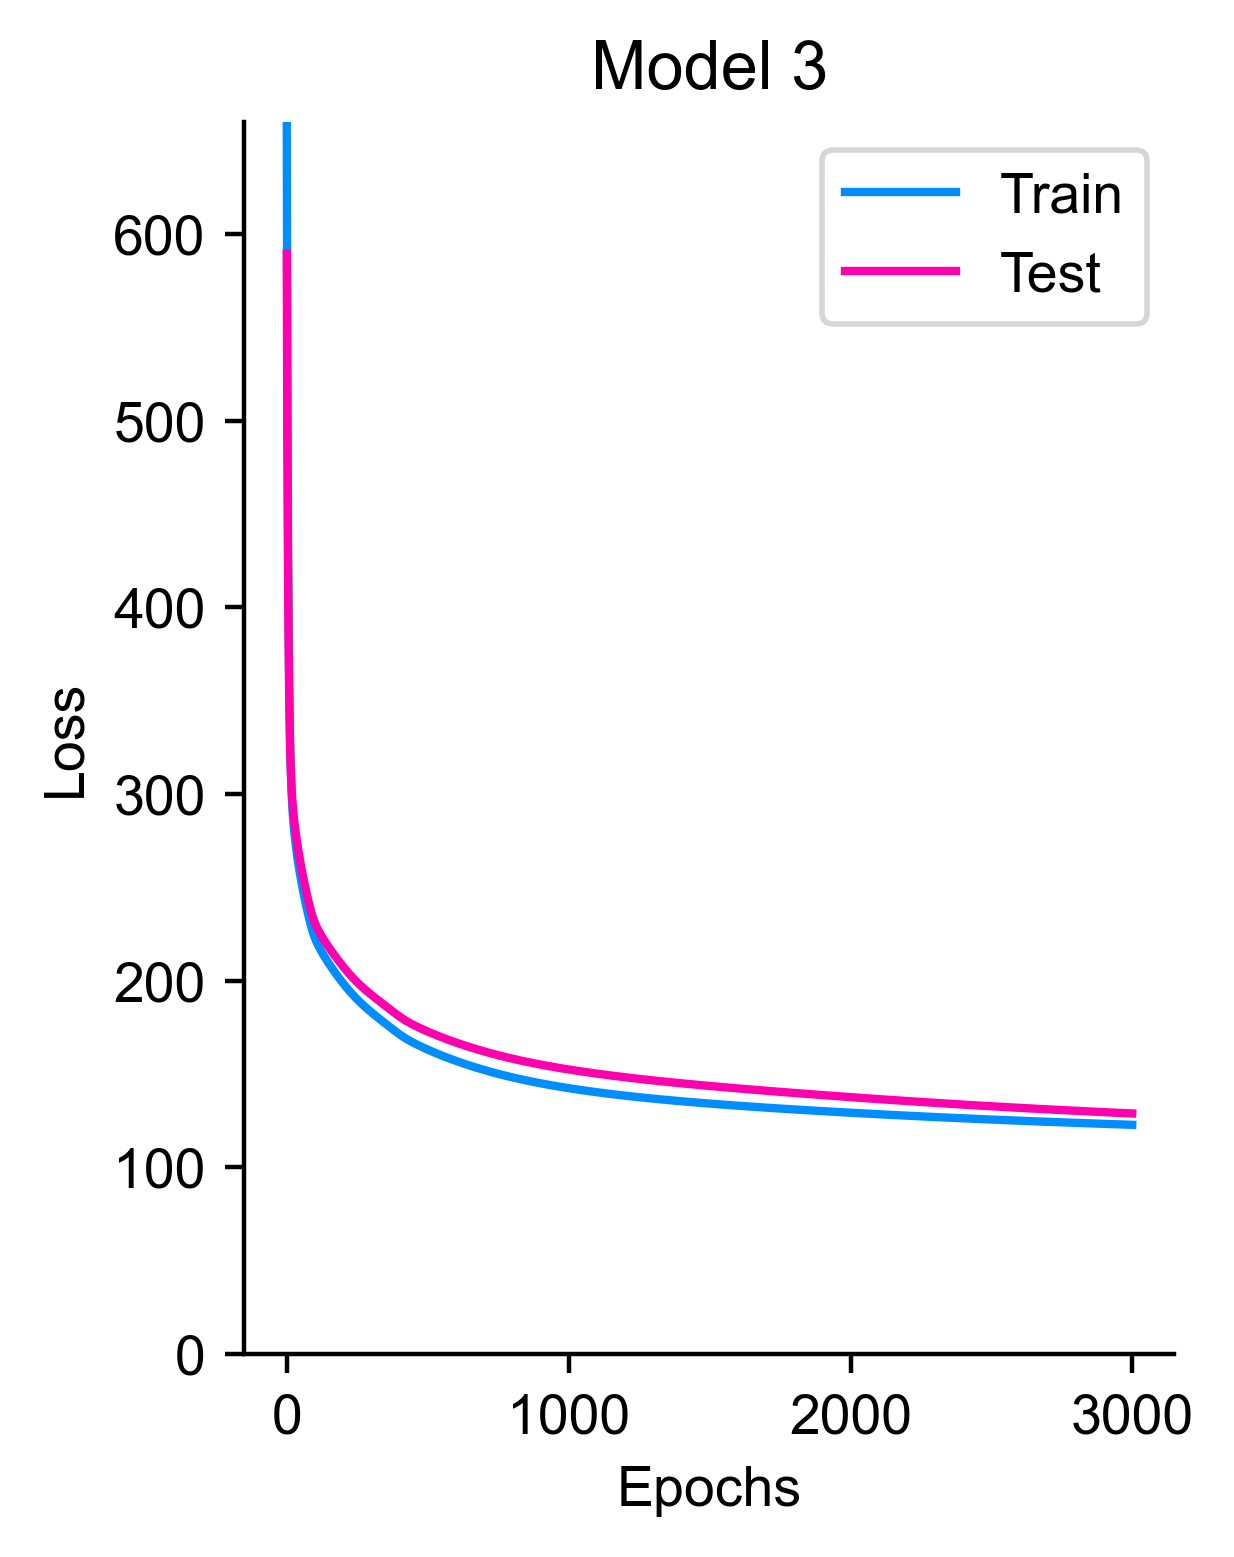

In [7]:
import numpy as np
import matplotlib.pyplot as plt


class NeuralLearner:
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        activation="relu",
        learning_rate=0.01,
        epochs=100,
    ):
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = {
            "W1": np.random.randn(hidden_size, input_size),
            "W2": np.random.randn(output_size, hidden_size),
        }
        self.loss_history = []
        self.val_loss_history = []

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward_pass(self, X):
        Z1 = np.dot(X, self.weights["W1"].T)
        H = self.relu(Z1) if self.activation == "relu" else self.tanh(Z1)
        Z2 = np.dot(H, self.weights["W2"].T)
        Y = Z2  # Linear activation for regression output
        return Y, Z2, H, Z1

    def back_propagation(self, X, Y_T):
        N_points = X.shape[0]
        Y, Z2, H, Z1 = self.forward_pass(X)
        L = (1 / N_points) * np.sum((Y - Y_T) ** 2)
        dLdY = 2 / N_points * (Y - Y_T)
        dLdW2 = np.dot(dLdY.T, H)
        dLdH = np.dot(dLdY, self.weights["W2"])
        if self.activation == "relu":
            dLdZ1 = dLdH * self.relu_derivative(Z1)
        else:
            dLdZ1 = dLdH * self.tanh_derivative(Z1)
        dLdW1 = np.dot(dLdZ1.T, X)
        gradients = {
            "W1": dLdW1,
            "W2": dLdW2,
        }
        return gradients, L

    def fit(self, X, y, X_val=None, y_val=None):
        X = X.reshape(-1, 1)  # Ensure X is a 2D array
        y = y.reshape(-1, 1)  # Ensure y is a 2D array
        for _ in range(self.epochs):
            gradients, loss = self.back_propagation(X, y)
            self.loss_history.append(loss)
            self.weights["W1"] -= self.learning_rate * gradients["W1"]
            self.weights["W2"] -= self.learning_rate * gradients["W2"]

            if X_val is not None and y_val is not None:
                val_loss = self.evaluate(X_val, y_val)
                self.val_loss_history.append(val_loss)

    def evaluate(self, X, y):
        X = X.reshape(-1, 1)  # Ensure X is a 2D array
        y = y.reshape(-1, 1)  # Ensure y is a 2D array
        y_pred, _, _, _ = self.forward_pass(X)
        return (1 / y.shape[0]) * np.sum((y_pred - y) ** 2)

    def predict(self, X):
        X = X.reshape(-1, 1)  # Ensure X is a 2D array
        y_pred, _, _, _ = self.forward_pass(X)
        return y_pred.flatten()


# Initialize and train a neural network
net = NeuralLearner(
    input_size=1,
    hidden_size=50,
    output_size=1,
    activation="sigmoid",
    learning_rate=0.001,
    epochs=3000,
)

net.fit(X_train, y_train, X_val, y_val)

# Plot training and validation loss history
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3, 4), dpi=200)
plt.plot(net.loss_history, label="Train", color="#008eff")
plt.plot(net.val_loss_history, label="Test", color="#ff00af")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, np.max(net.loss_history))
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.title("Model 3")
plt.show()

MSE: 122.7469


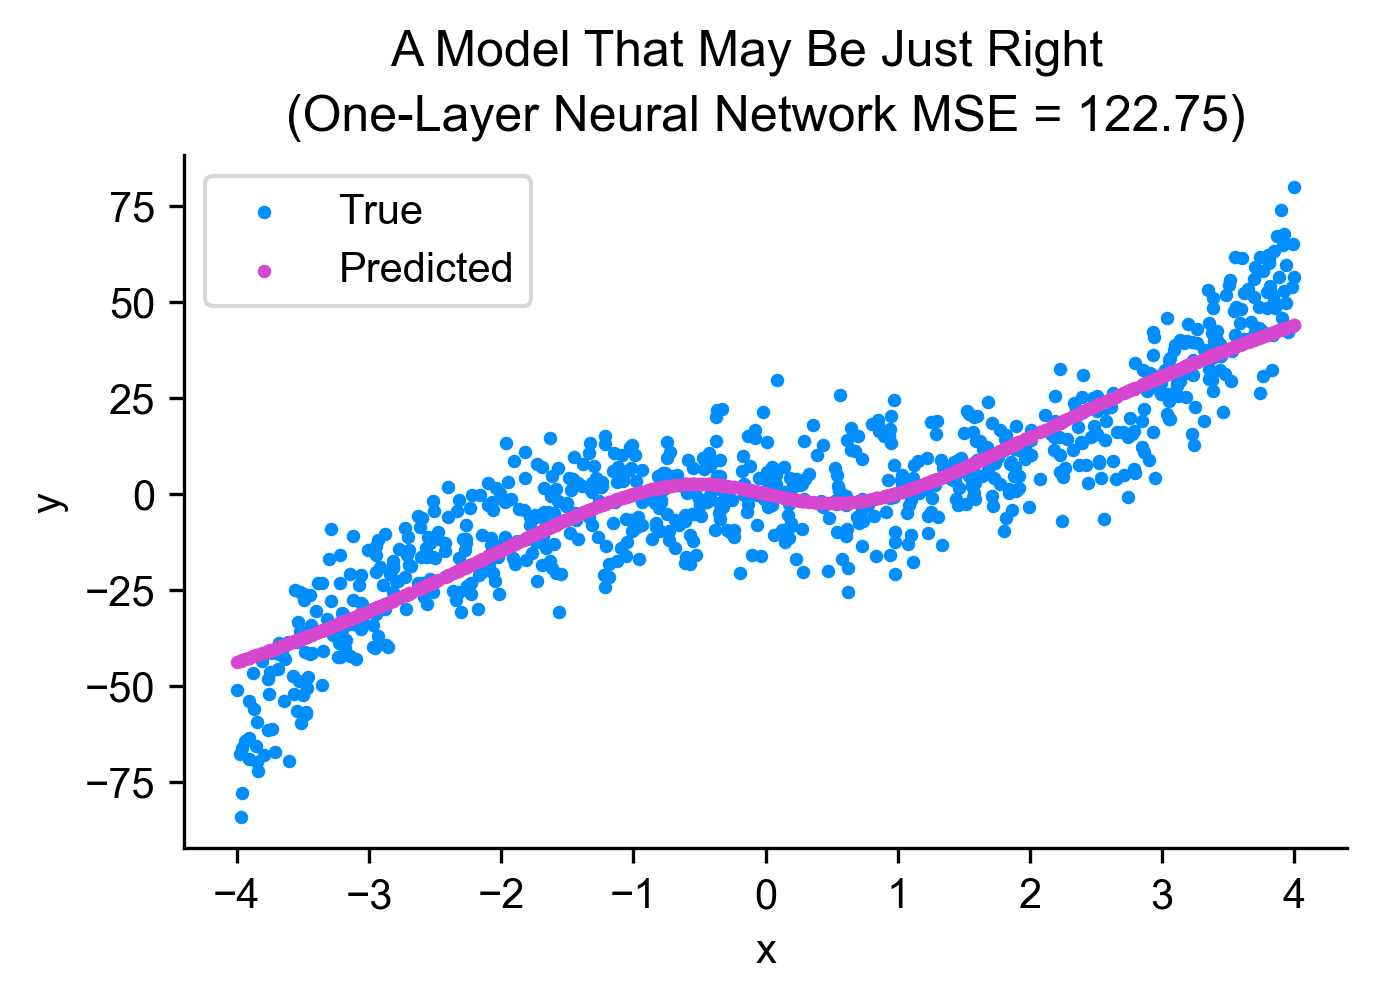

In [8]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

y_pred = net.predict(X_train).ravel()

mse = mean_squared_error(y_train, y_pred)
print(f"MSE: {mse:.4f}")

fig = plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X_train, y_train, color="#008eff", label="True", s=5)
plt.scatter(X_train, y_pred, color="#d647cf", label="Predicted", s=5)
plt.legend()
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title(f"(One-Layer Neural Network MSE = {mse:.2f})")
plt.suptitle("A Model That May Be Just Right", y=1.02)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Plot different models

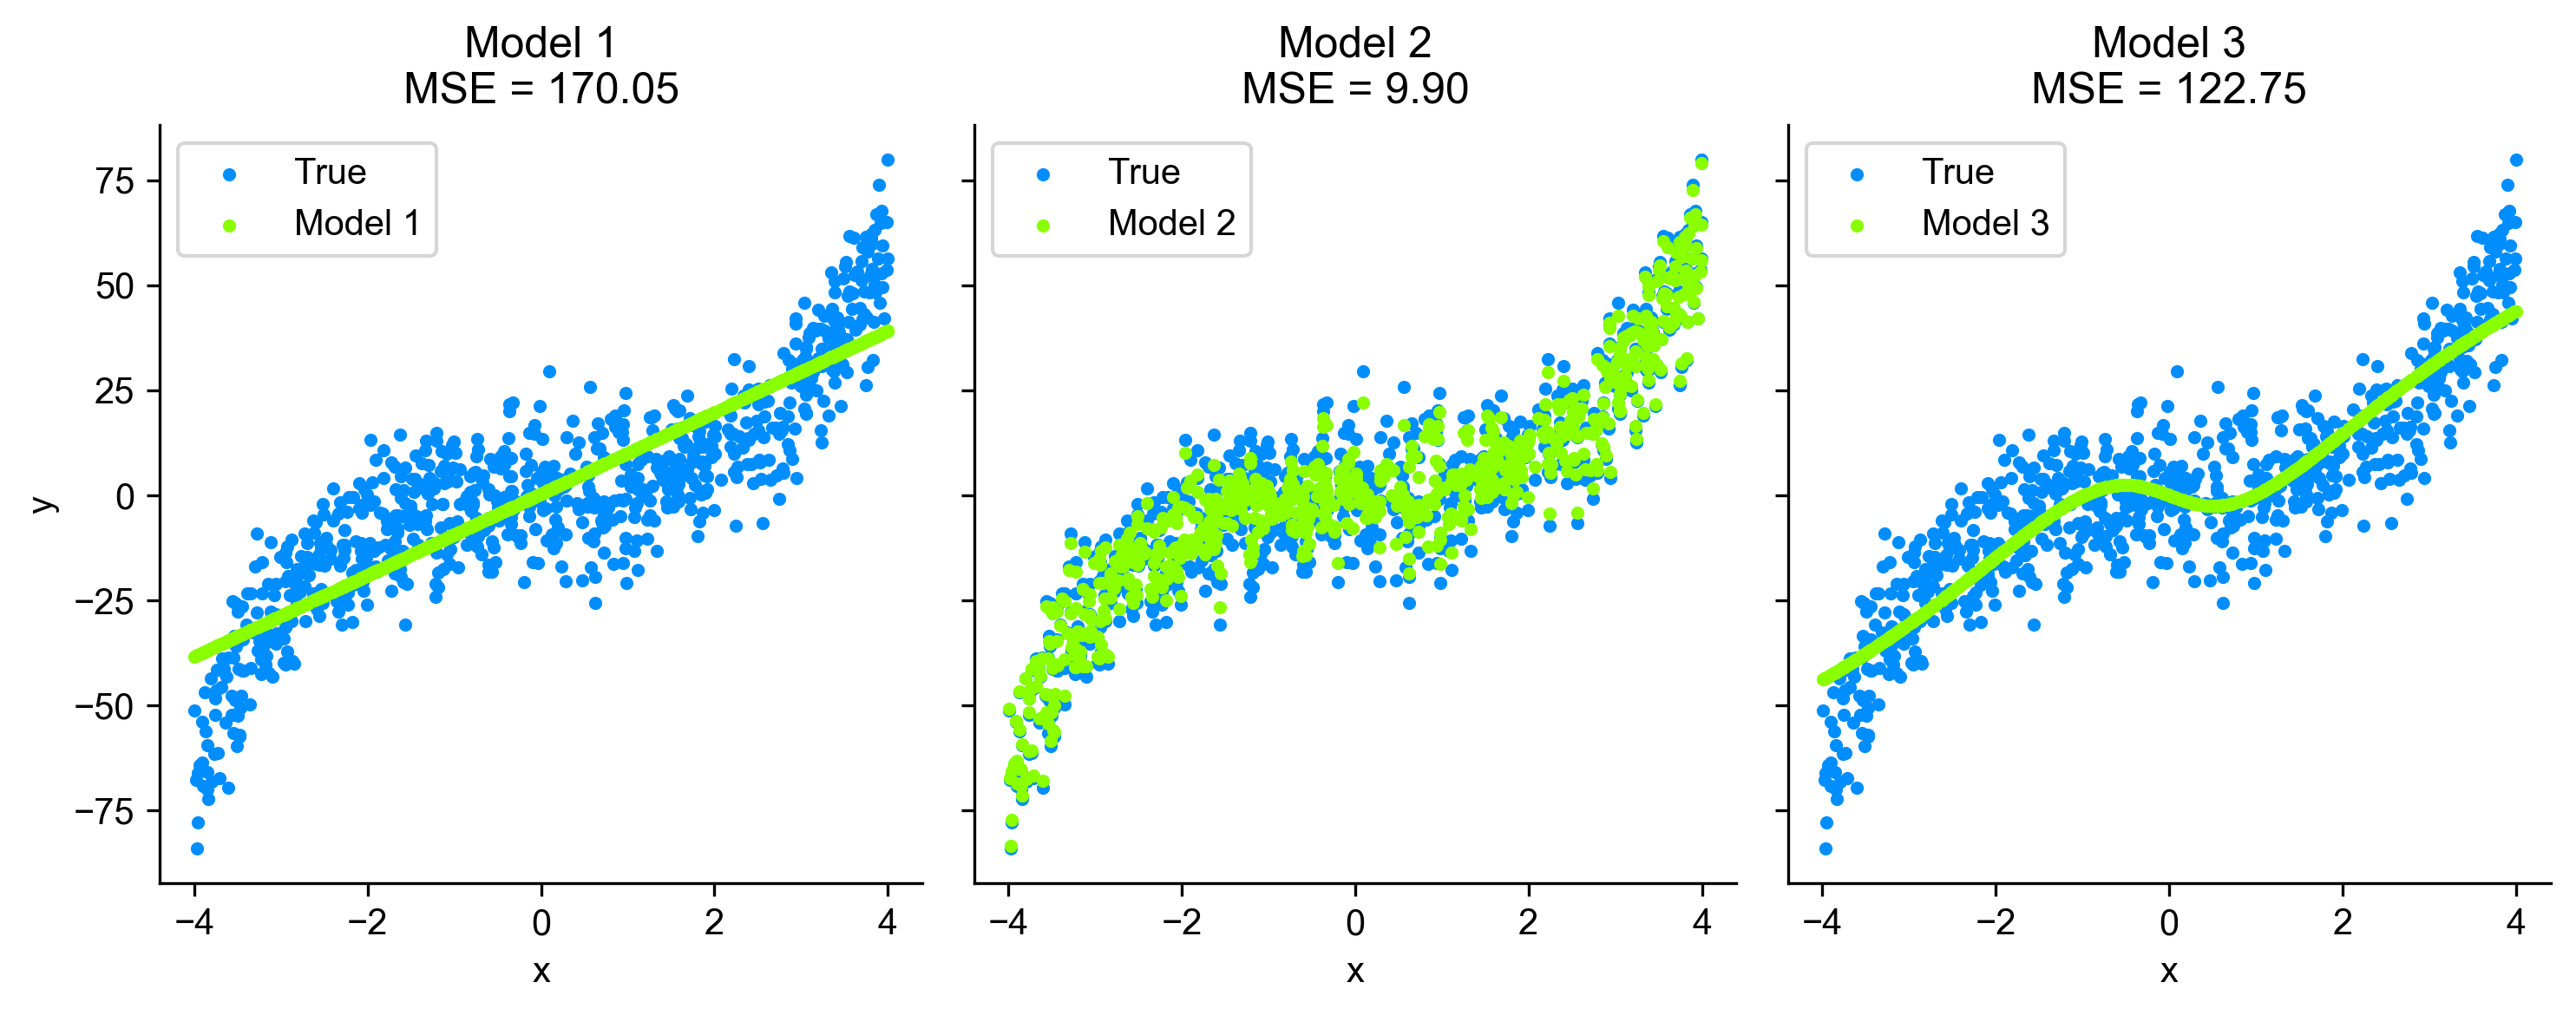

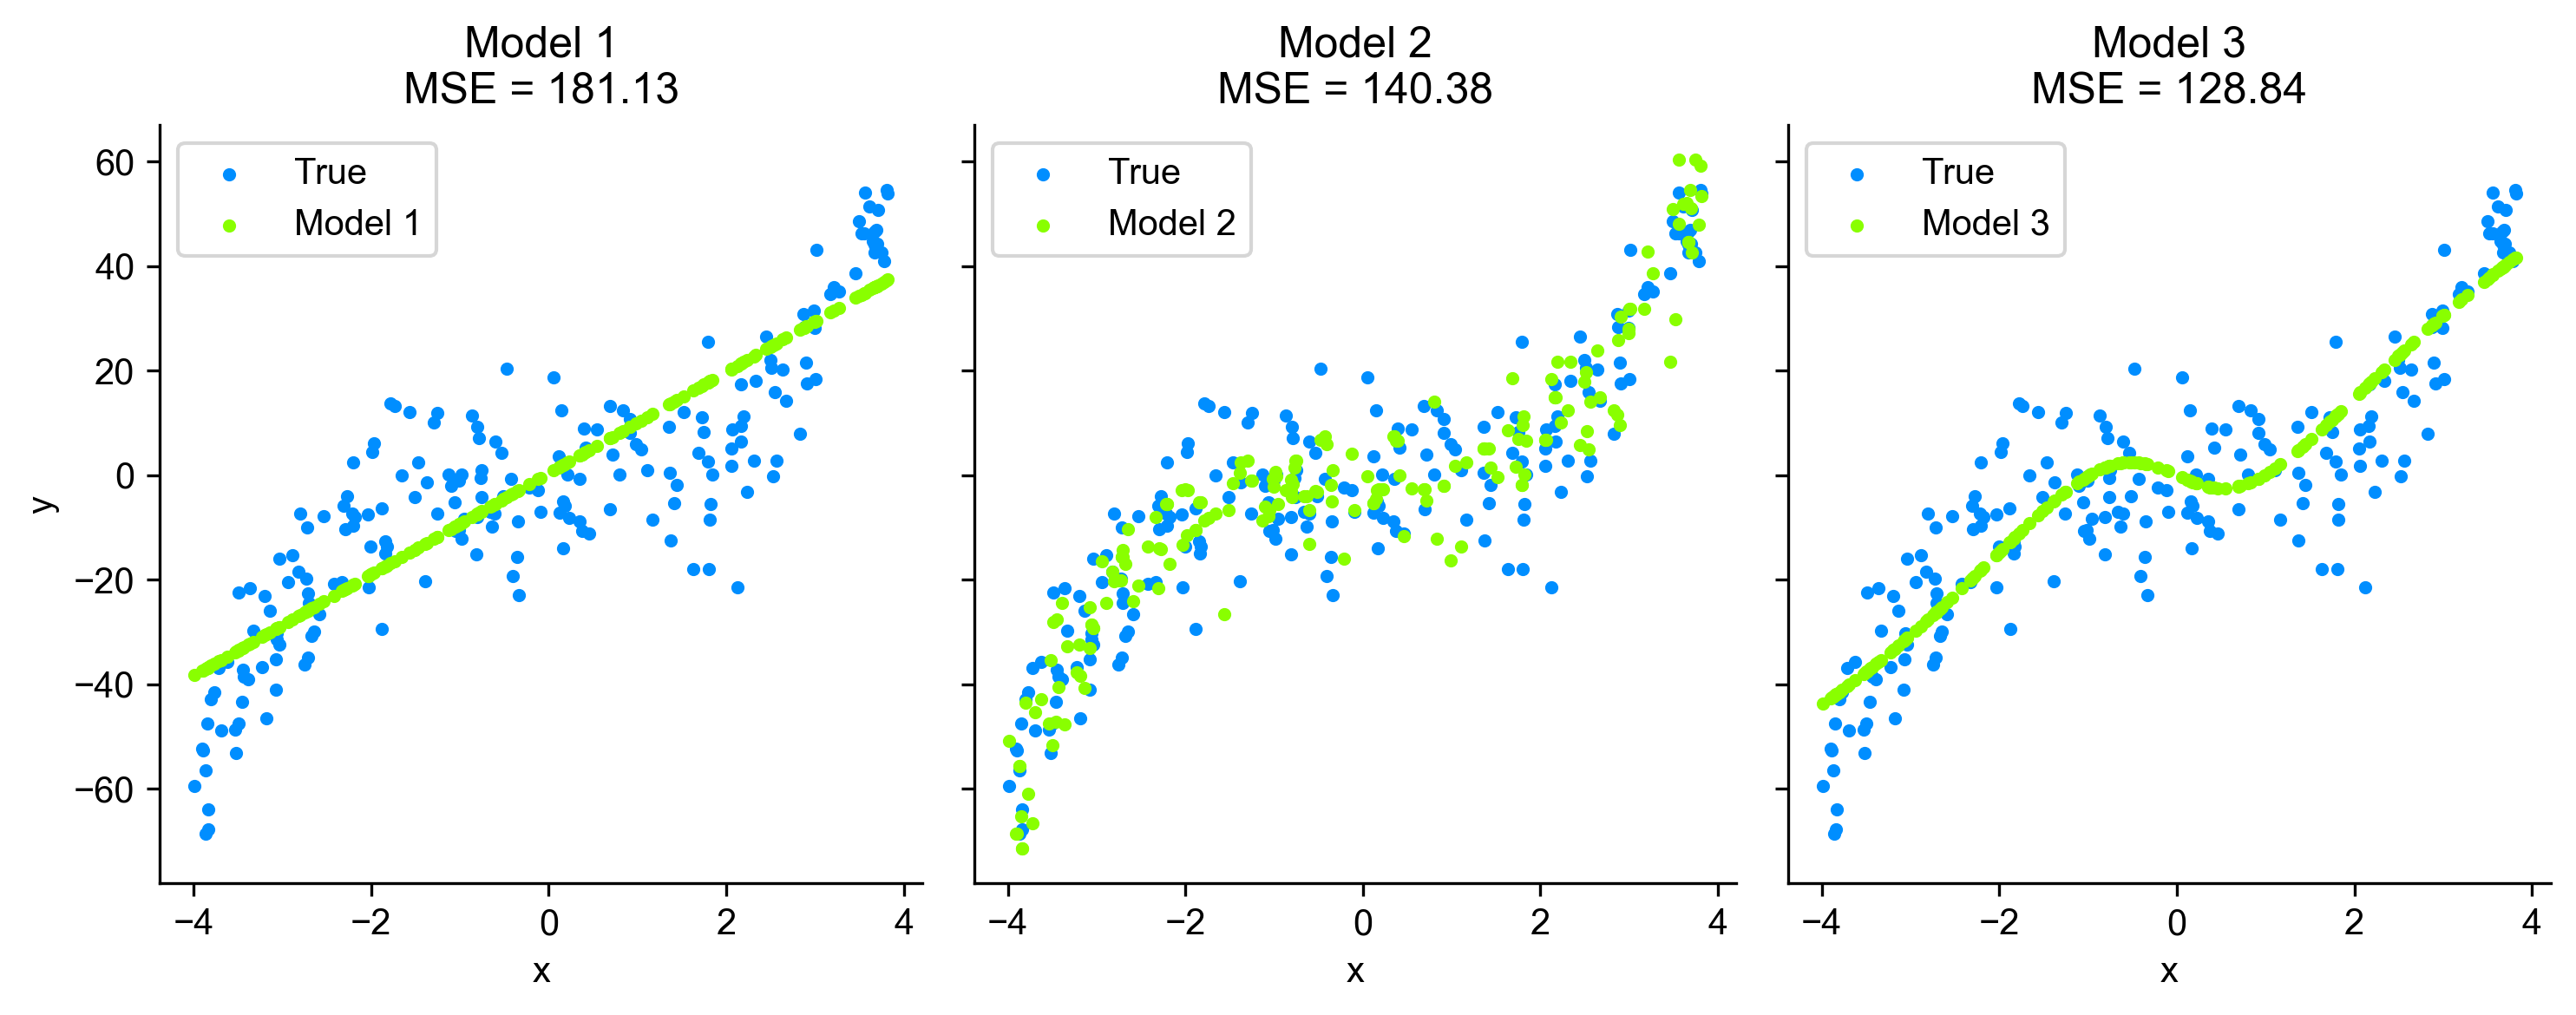

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def plot_multiple_predictions(
    x, y, predictions_linear, predictions_dt, predictions_nn, params=None
):
    if params is None:
        params = {"s": 7}
    mses = [
        mean_squared_error(y, pred)
        for pred in [predictions_linear, predictions_dt, predictions_nn]
    ]
    titles = ["Model 1", "Model 2", "Model 3"]

    fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=150)
    for i, (ax, pred, mse, title) in enumerate(
        zip(axs, [predictions_linear, predictions_dt, predictions_nn], mses, titles)
    ):
        ax.scatter(x, y, color="#008eff", label="True", s=params["s"])
        ax.scatter(x, pred, color="#89ff00", label=title, s=params["s"])
        ax.legend()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_title(f"{title}\nMSE = {mse:.2f}")
        ax.set_xlabel("x")
        if i == 0:
            ax.set_ylabel("y")
    plt.tight_layout()
    plt.show()


# Function to get predictions and plot
def get_predictions_and_plot(lr, gbr, net, X, y, title):
    predictions = [lr.predict(X), gbr.predict(X.reshape(-1, 1)), net.predict(X).ravel()]
    plot_multiple_predictions(X, y, *predictions)


get_predictions_and_plot(lr, gbr, net, X_train, y_train, "Train Data")
get_predictions_and_plot(lr, gbr, net, X_val, y_val, "Validation Data")

In [10]:
from sklearn.metrics import r2_score

# Get predictions on the training set
predictions = [
    lr.predict(X_train),
    gbr.predict(X_train.reshape(-1, 1)),
    net.predict(X_train).ravel(),
]

# calculate R2 score
r2_scores = [r2_score(y_train, pred) for pred in predictions]
r2_scores

[0.7469923783878887, 0.9852731174275603, 0.8173745796047656]

In [11]:
from sklearn.metrics import r2_score

# Get predictions on the test set
predictions = [
    lr.predict(X_val),
    gbr.predict(X_val.reshape(-1, 1)),
    net.predict(X_val).ravel(),
]

# calculate R2 score
r2_scores = [r2_score(y_val, pred) for pred in predictions]
r2_scores

[0.7269894228372699, 0.7884170415603063, 0.8058071124095161]

## Bias and Variance Decomposition

We use the code adapted from `mlxtend` to plot the bias and variance decomposition.

We use similar scikit-learn estimators here for a proper integration with the `mlxtend` code.

In [12]:
import numpy as np

np.random.seed(0)


def bias_variance(
    estimator,
    X,
    y,
    n_bootstraps=50,
    X_val=None,
    y_val=None,
    refit=True,
    sample_size=0.1,
):
    np.random.seed(0)
    n_samples = int(len(X) * sample_size)
    y_pred = np.zeros((len(X), n_bootstraps))

    # Bootstrapping for training set
    for i in range(n_bootstraps):
        idx = np.random.choice(len(X), n_samples, replace=True)
        if refit:
            X_boot = X[idx]
            y_boot = y[idx]
            estimator.fit(X_boot, y_boot)
        y_pred[:, i] = estimator.predict(X).ravel()

    avg_y_pred = np.mean(y_pred, axis=1)
    bias = np.mean((y - avg_y_pred) ** 2)
    variance = np.mean((y_pred - avg_y_pred[:, np.newaxis]) ** 2)

    # Bootstrapping for validation set (if available)
    if X_val is not None and y_val is not None:
        y_val_pred = np.zeros((len(X_val), n_bootstraps))
        biases = []
        variances = []

        # For each bootstrap, predict on a bootstrapped subset of the validation set
        for _ in range(n_bootstraps):
            # Randomly select a subset from the validation set
            idx_val = np.random.choice(len(X_val), n_samples, replace=True)
            X_boot_val = X_val[idx_val]
            y_boot_val = y_val[idx_val]

            # Make predictions on the bootstrapped validation subset
            y_val_pred_subset = estimator.predict(X_boot_val).ravel()

            # Calculate bias for this subset
            bias_subset = np.mean((y_boot_val - np.mean(y_val_pred_subset)) ** 2)
            biases.append(bias_subset)

            # Calculate variance for this subset
            variance_subset = np.mean(
                (y_val_pred_subset - np.mean(y_val_pred_subset)) ** 2
            )
            variances.append(variance_subset)

        # Average bias and variance over all bootstraps
        bias_val = np.mean(biases)
        variance_val = np.mean(variances)

        return (bias, variance), (bias_val, variance_val)

    return bias, variance


X_train = X_train.reshape(-1, 1)
X_val = X_val.reshape(-1, 1)

lr_params = {"learning_rate": 1e-5, "epochs": 5}
gb_params = {"n_iter": 5, "max_depth": 2, "learning_rate": 0.01, "base_learner": "tree"}
nn_params = {
    "input_size": 1,
    "hidden_size": 50,
    "output_size": 1,
    "activation": "sigmoid",
    "learning_rate": 0.001,
    "epochs": 100,
}

bias_lr, var_lr = bias_variance(LinearEstimator(**lr_params), X_train, y_train)
bias_gb, var_gb = bias_variance(GradientBooster(**gb_params), X_train, y_train)
bias_nn, var_nn = bias_variance(NeuralLearner(**nn_params), X_train, y_train)

['MSE = 663.27', 'MSE = 349.92', 'MSE = 135.90']


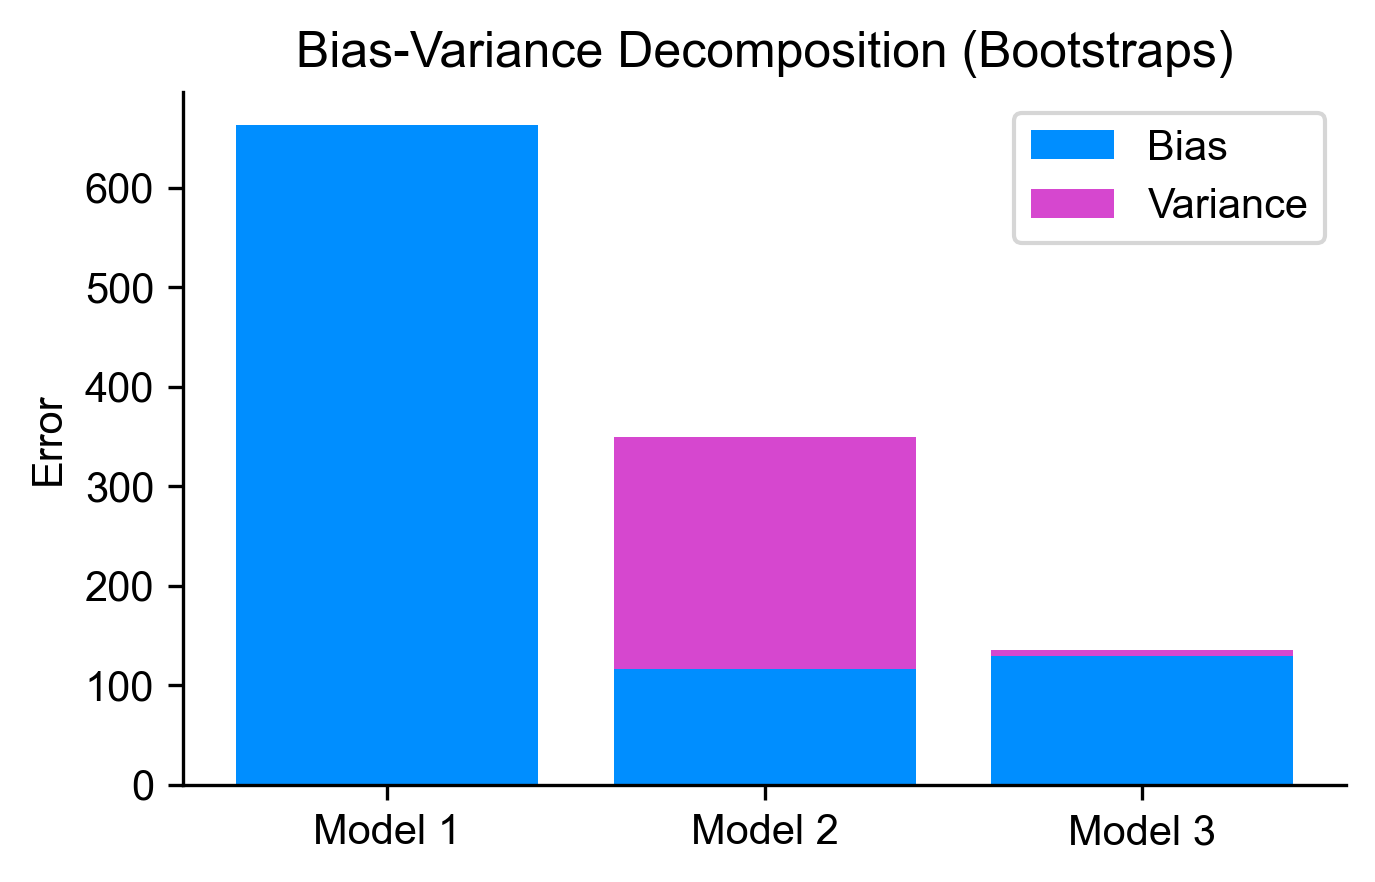

In [13]:
mses = [bias_lr + var_lr, bias_gb + var_gb, bias_nn + var_nn]
print([f"MSE = {mse:.2f}" for mse in mses])

# visualize bias and variance across models
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.bar(
    ["Model 1", "Model 2", "Model 3"],
    [bias_lr, bias_gb, bias_nn],
    color="#008eff",
    label="Bias",
)
plt.bar(
    ["Model 1", "Model 2", "Model 3"],
    [var_lr, var_gb, var_nn],
    color="#d647cf",
    label="Variance",
    bottom=[bias_lr, bias_gb, bias_nn],
)
plt.legend()
# disable spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title("Bias-Variance Decomposition (Bootstraps)")
plt.ylabel("Error")
plt.show()

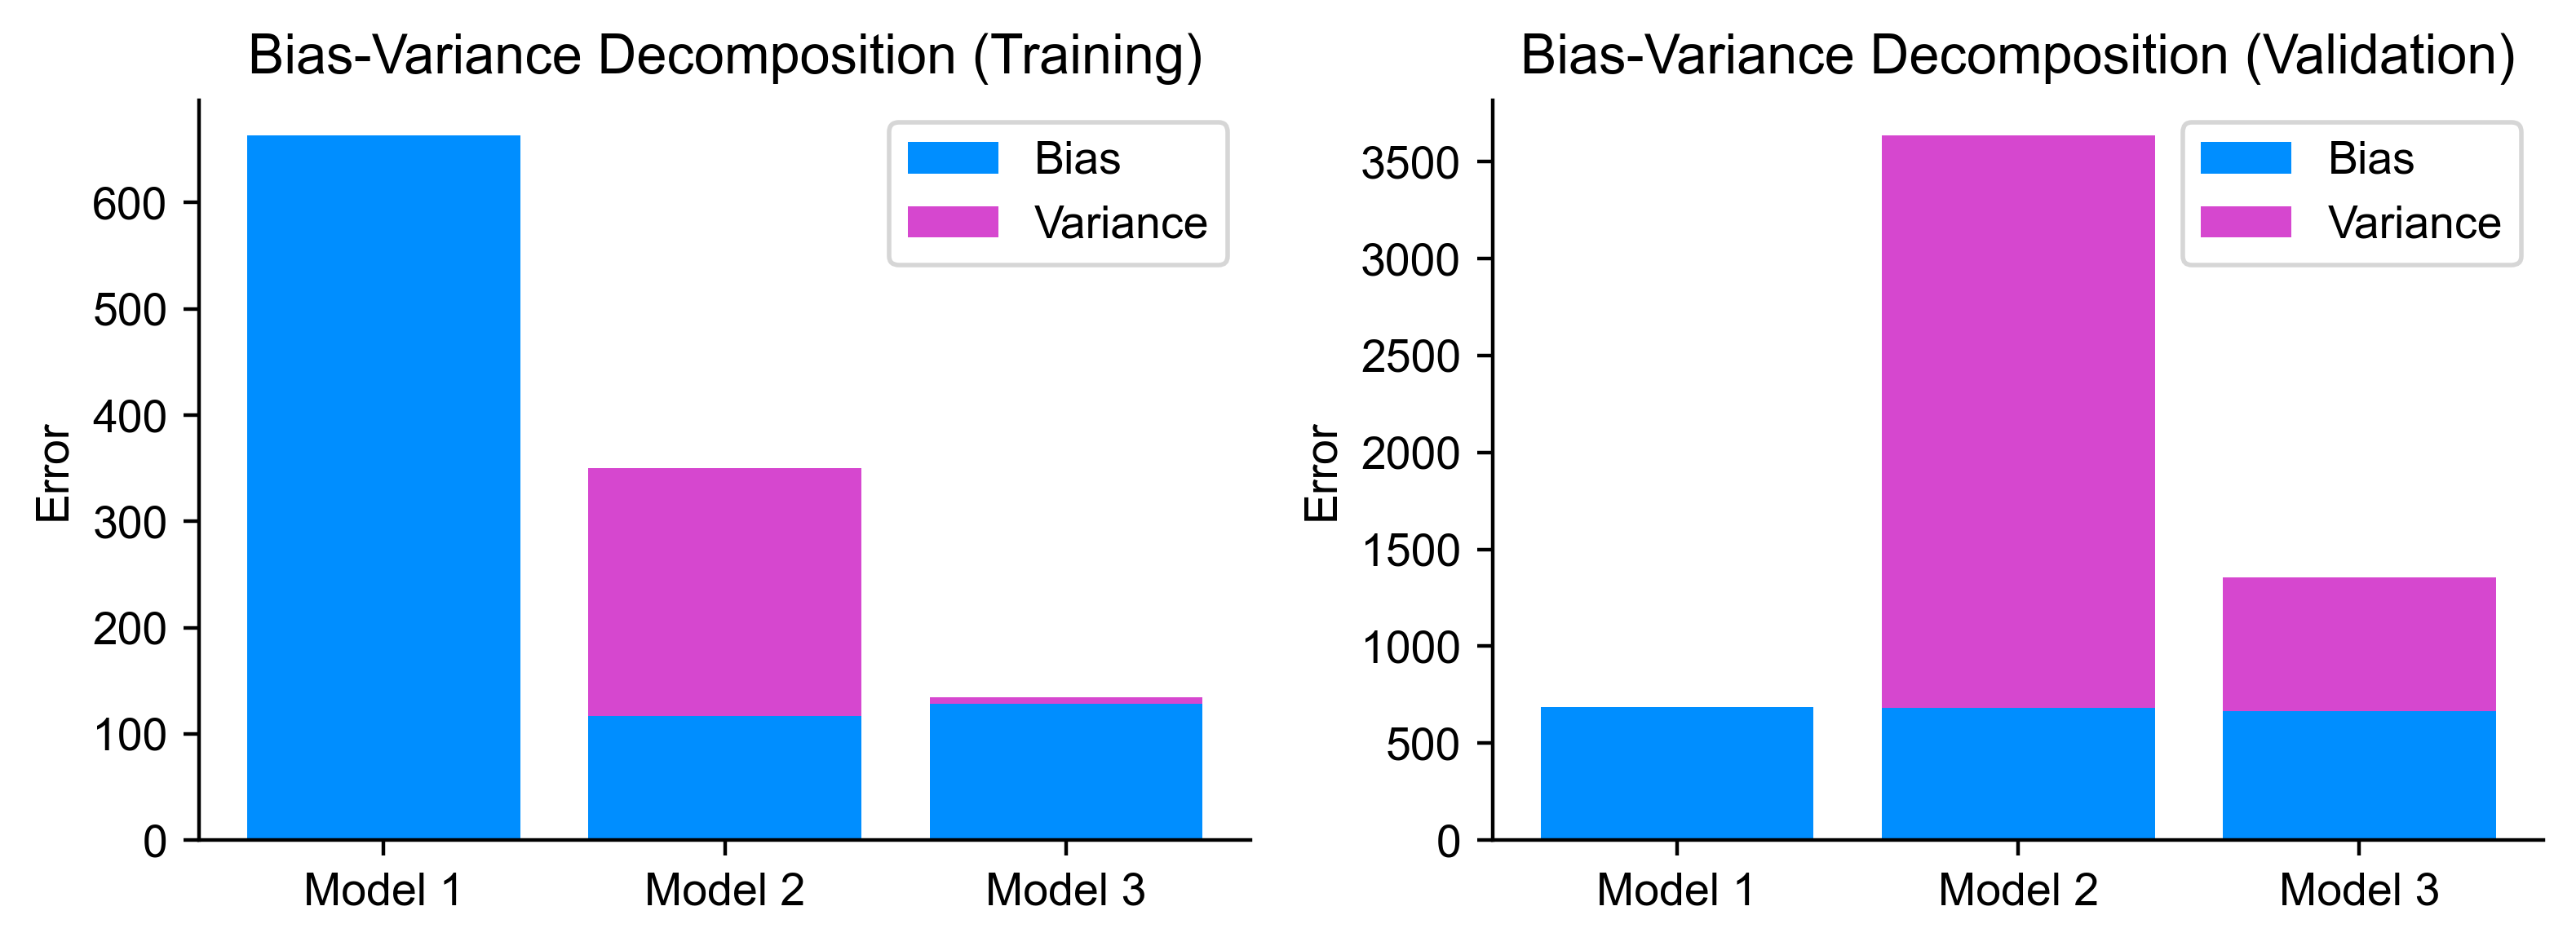

In [14]:
import matplotlib.pyplot as plt

# Calculate validation and training set bias and variance
trn_bias_var_lr, val_bias_var_lr = bias_variance(
    LinearEstimator(**lr_params), X_train, y_train, X_val=X_val, y_val=y_val
)
trn_bias_var_gb, val_bias_var_gb = bias_variance(
    GradientBooster(**gb_params), X_train, y_train, X_val=X_val, y_val=y_val
)
trn_bias_var_nn, val_bias_var_nn = bias_variance(
    NeuralLearner(**nn_params), X_train, y_train, X_val=X_val, y_val=y_val
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

# Plot for training set bias and variance
axes[0].bar(
    ["Model 1", "Model 2", "Model 3"],
    [trn_bias_var_lr[0], trn_bias_var_gb[0], trn_bias_var_nn[0]],
    color="#008eff",
    label="Bias",
)
axes[0].bar(
    ["Model 1", "Model 2", "Model 3"],
    [trn_bias_var_lr[1], trn_bias_var_gb[1], trn_bias_var_nn[1]],
    color="#d647cf",
    label="Variance",
    bottom=[trn_bias_var_lr[0], trn_bias_var_gb[0], trn_bias_var_nn[0]],
)
axes[0].legend()
axes[0].set_title("Bias-Variance Decomposition (Training)")
axes[0].set_ylabel("Error")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Plot for validation set bias and variance
axes[1].bar(
    ["Model 1", "Model 2", "Model 3"],
    [val_bias_var_lr[0], val_bias_var_gb[0], val_bias_var_nn[0]],
    color="#008eff",
    label="Bias",
)
axes[1].bar(
    ["Model 1", "Model 2", "Model 3"],
    [val_bias_var_lr[1], val_bias_var_gb[1], val_bias_var_nn[1]],
    color="#d647cf",
    label="Variance",
    bottom=[val_bias_var_lr[0], val_bias_var_gb[0], val_bias_var_nn[0]],
)
axes[1].legend()
axes[1].set_title("Bias-Variance Decomposition (Validation)")
axes[1].set_ylabel("Error")
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

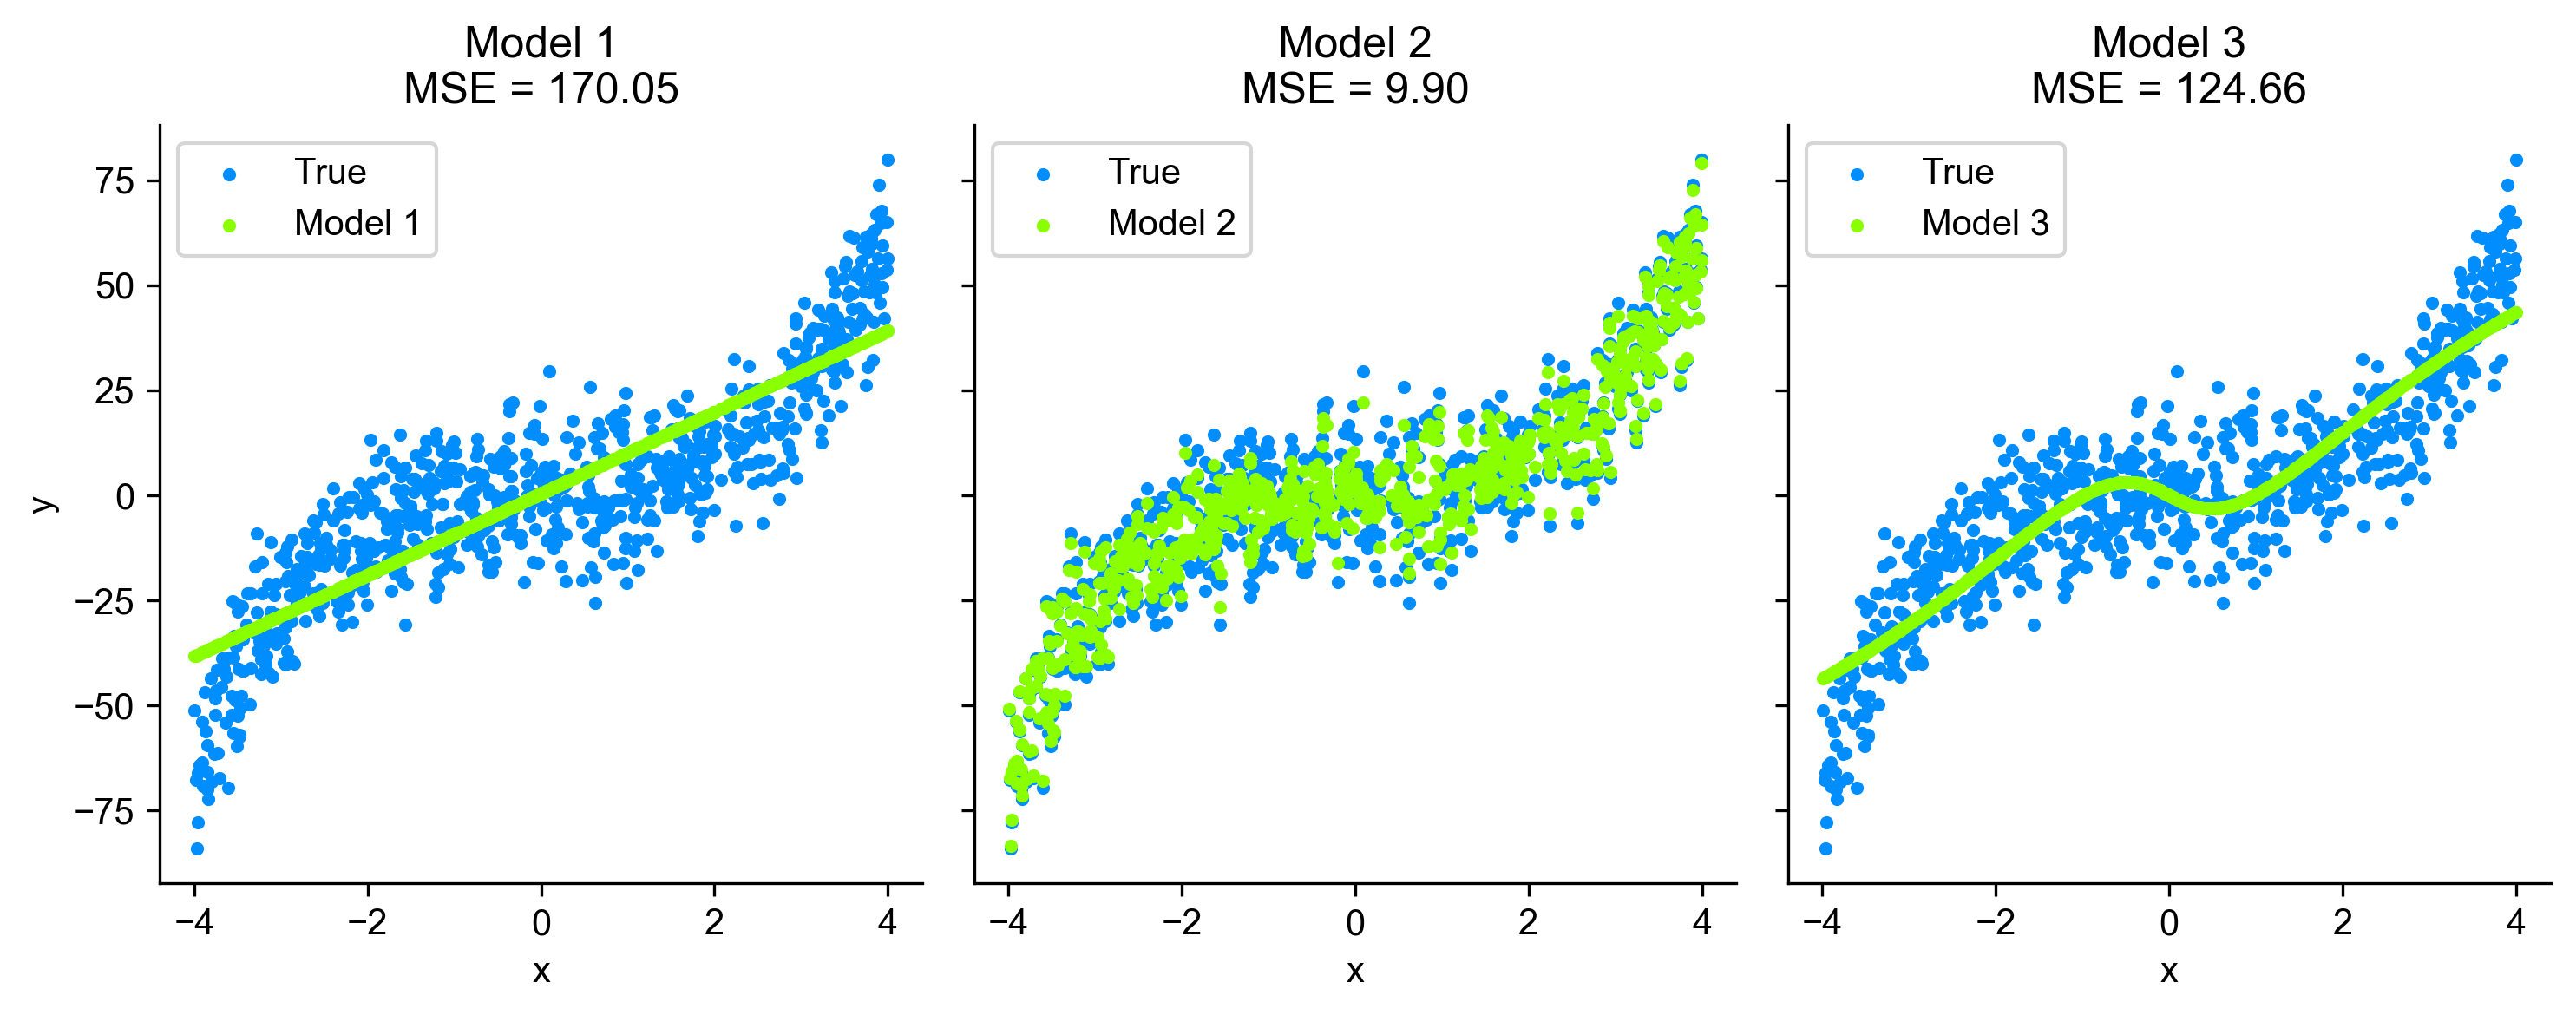

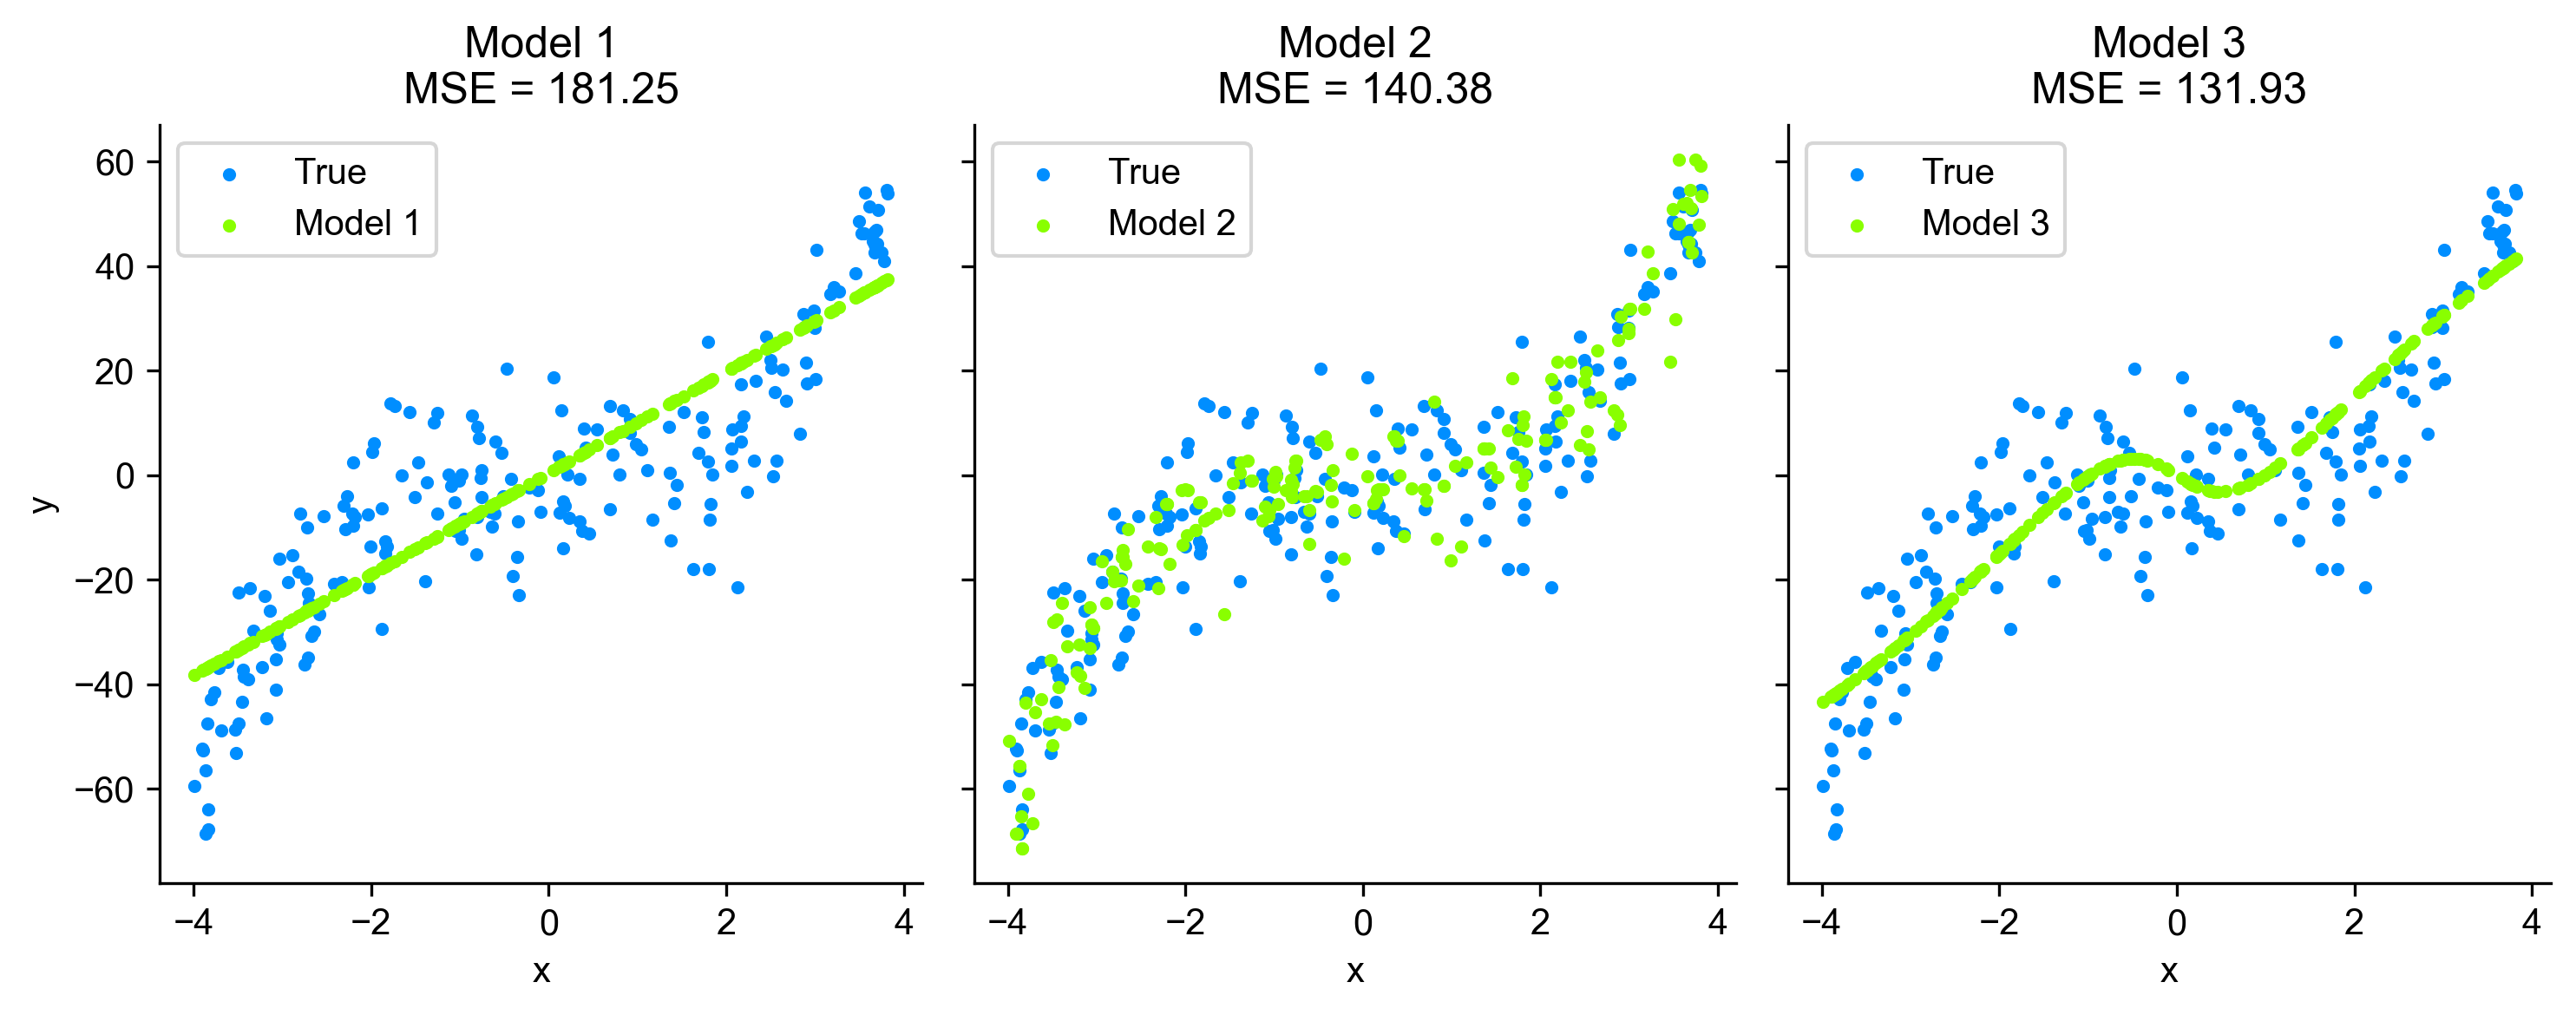

In [15]:
def get_predictions_and_plot(model_1, model_2, model_3, X, y, title):
    predictions = [
        model_1.predict(X),
        model_2.predict(X.reshape(-1, 1)),
        model_3.predict(X).ravel(),
    ]
    plot_multiple_predictions(X, y, *predictions)


linear = LinearRegression()
gb = GradientBooster(n_iter=50, max_depth=10, learning_rate=0.1, base_learner="tree")
mlp = NeuralLearner(
    input_size=1,
    hidden_size=50,
    output_size=1,
    activation="sigmoid",
    learning_rate=0.001,
    epochs=3000,
)

# fit each model on the training data
for model in [linear, gb, mlp]:
    model.fit(X_train, y_train)

get_predictions_and_plot(linear, gb, mlp, X_train, y_train, title="Train Data")
get_predictions_and_plot(linear, gbr, mlp, X_val, y_val, title="Validation Data")